# Imports

In [1]:
%cd ..

c:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time

from mva_independent_component_analysis.utils.preprocessing import centering_and_whitening
from mva_independent_component_analysis.fast_ica.fastica_numpy import fast_ica 

# Generating non-Gaussian sources and mixing them

In [18]:
# Set seed for reproducibility
np.random.seed(0)

# Generate time samples
t = np.linspace(0, 200, 1000)

# Sources
source_1 = np.sin(t*2)
source_2 = 2 * (1.9*t % (2 * np.pi)) / (2 * np.pi) - 1  # Sawtooth wave approximation
source_3 = np.random.random(len(t))

# Stack sources to form S matrix
S = np.array([source_1, source_2, source_3])

# Mixing process
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signals
X = A @ S

# Number of sources, samples, and signals
n_sources, n_samples = S.shape
n_signals = X.shape[0]


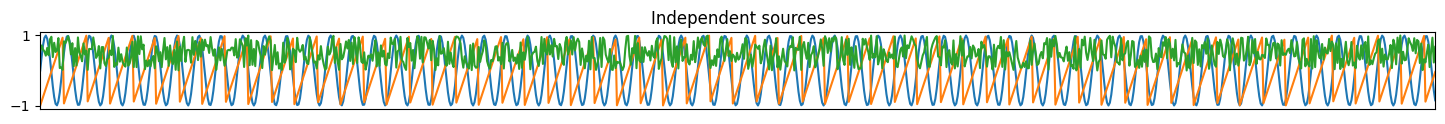

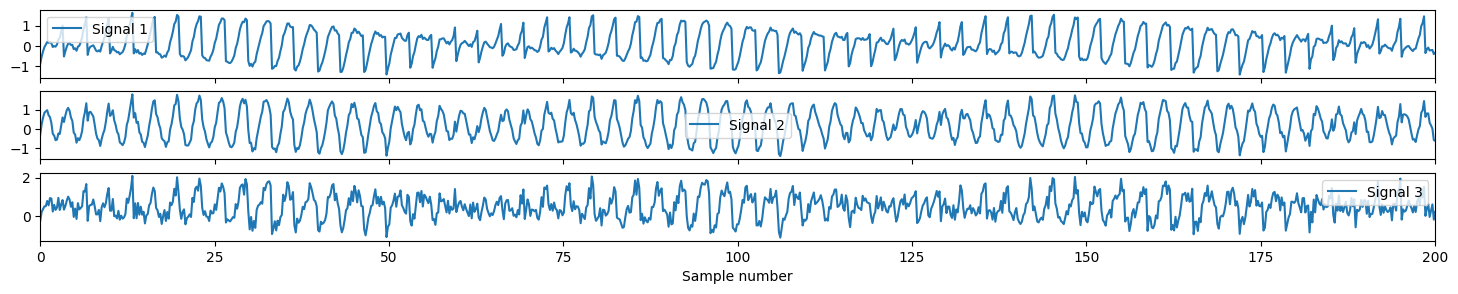

In [19]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 1])
ax.plot(t, S.T)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(t[0], t[-1])
ax.tick_params()
ax.set_title('Independent sources')

fig, ax = plt.subplots(n_signals, 1, figsize=[18, 3], sharex=True)
for signal_number, observed_signal in enumerate(X):
    ax[signal_number].plot(t, X[signal_number], label=f"Signal {signal_number + 1}")
    ax[signal_number].tick_params()
    ax[signal_number].legend()

ax[-1].set_xlabel('Sample number')
ax[-1].set_xlim(t[0], t[-1])
plt.show()

### A visual non-Gaussianity test

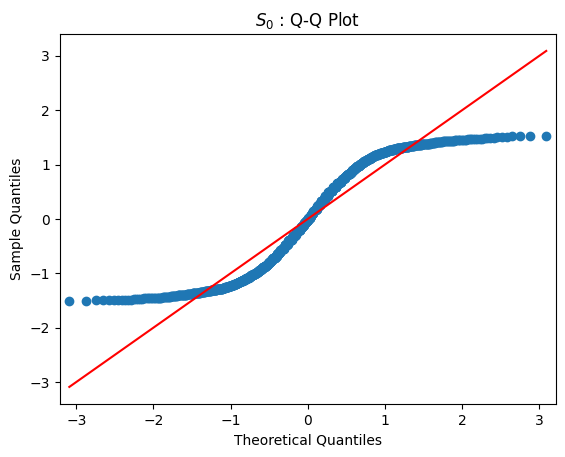

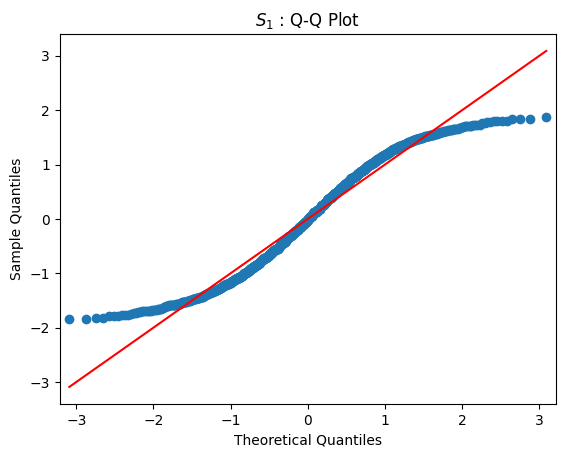

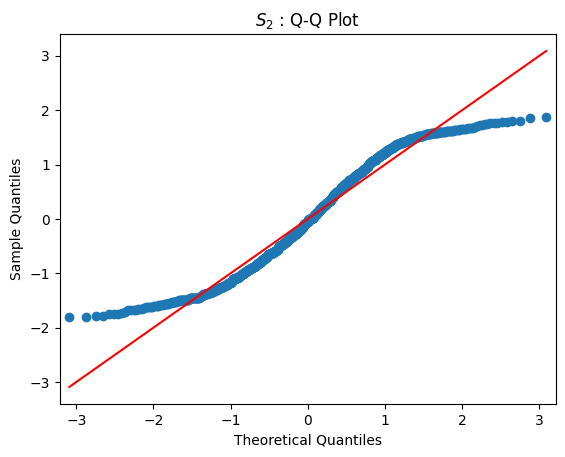

In [25]:
Sw, _, _ = centering_and_whitening(S)
import statsmodels.api as sm
# Create a Q-Q plot
for i in range(n_sources):
    sm.qqplot(Sw[i], line='s')
    plt.title(f'$S_{i}$ : Q-Q Plot')
    plt.show()


# ICA

In [40]:
# Center & whiten signals
X, meanX, whiteM = centering_and_whitening(X)
start_time=time.time()
W = fast_ica(X)
end_time=time.time()
print(f'Took {end_time-start_time} s to run')

unMixed = np.dot(W,X)

component 0
iteration : 0 : distance 0.15561717748641968
iteration : 1 : distance 0.013290941715240479
iteration : 2 : distance 6.616115570068359e-06
iteration : 3 : distance 1.1920928955078125e-07
iteration : 4 : distance 0.0
component 1
iteration : 0 : distance 0.7970742732286453
iteration : 1 : distance 0.019132375717163086
iteration : 2 : distance 0.00018066167831420898
iteration : 3 : distance 4.172325134277344e-07
iteration : 4 : distance 0.0
component 2
iteration : 0 : distance 0.0038687586784362793
iteration : 1 : distance 5.960464477539063e-08
iteration : 2 : distance 5.960464477539063e-08
Took 0.013055562973022461 s to run


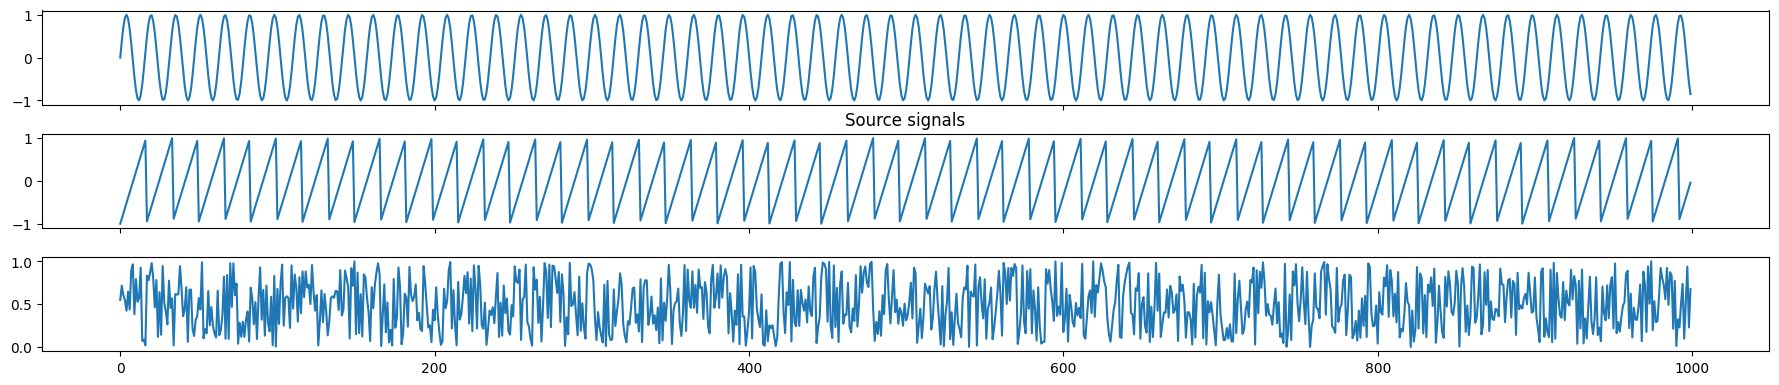

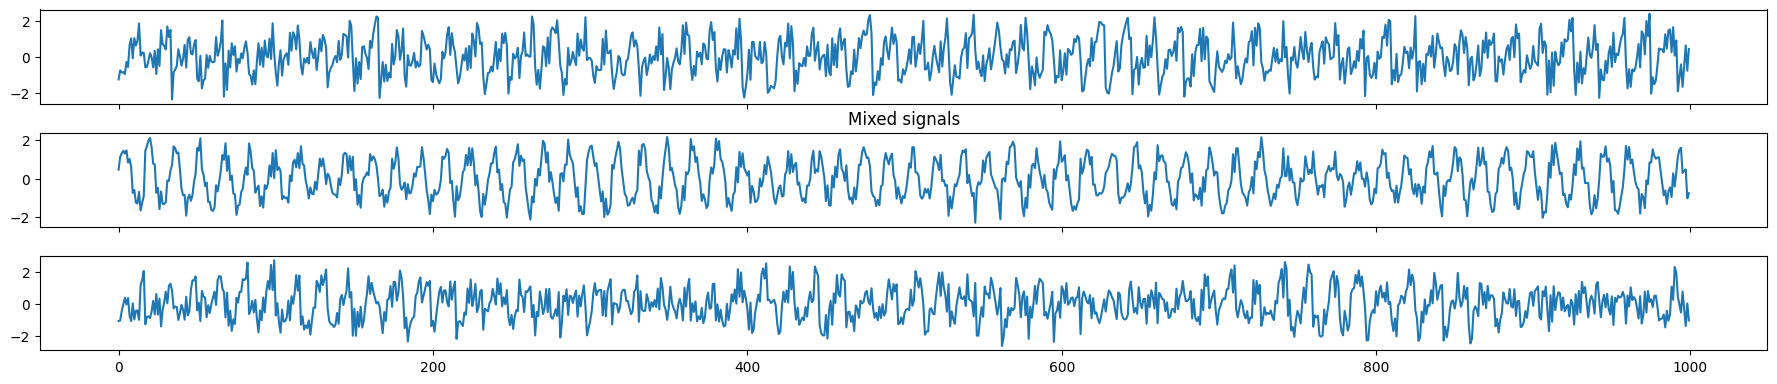

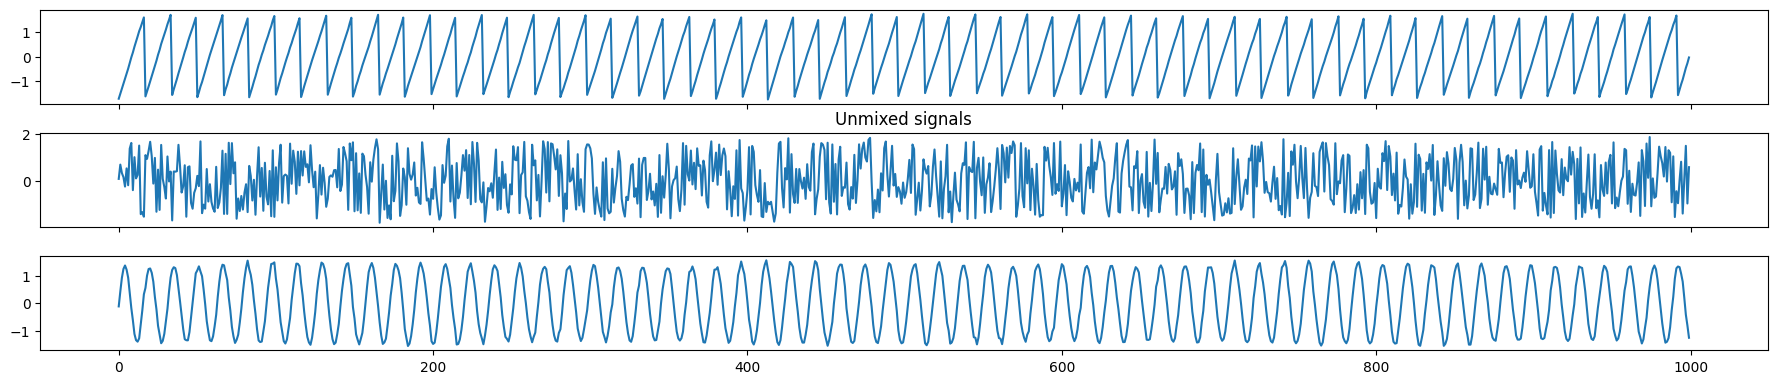

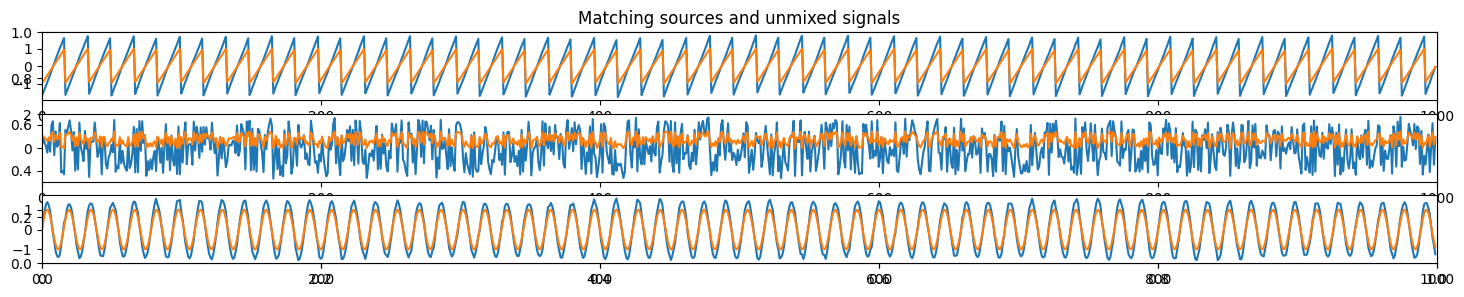

In [41]:
# Plot input signals (not mixed)
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[1].set_title('Source signals')
for i in range(n_signals):
    axes[i].plot(S[i])

# Plot mixed signals 
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[1].set_title('Mixed signals')
for i in range(n_signals):
    axes[i].plot(X[i])


# Plot recovered signals (unmixed)
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[1].set_title('Unmixed signals')
for i in range(n_signals):
    axes[i].plot(unMixed[i])

Sw, _, _ = centering_and_whitening(S)

plt.figure(figsize=(18,3))
plt.title("Matching sources and unmixed signals")
for i in range(X.shape[0]):
    perm = np.argmax(np.abs(unMixed[i,:] @ Sw.T))
    plt.subplot(3,1,i+1)
    plt.plot(unMixed[i,:].T)
    plt.plot(S[perm].T)
    plt.xlim(0, S.shape[1])
    # ax.set_ylim(-1.5, 1.5)


